In [131]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

In [132]:
mnist_train = dsets.MNIST(
    root='../data/mnist/',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

mnist_test = dsets.MNIST(
    root='../data/mnist/',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

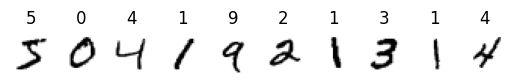

In [133]:
_show = 10

for i in range(_show):
    plt.subplot(1, _show, i + 1)
    plt.axis('off')
    plt.imshow(mnist_train.data[i].numpy(), cmap='gray_r')
    plt.title(mnist_train.targets[i].item())

In [134]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [135]:
batch_size = 100    # train_data size: 60000

data_loader = DataLoader(
    dataset=mnist_train,
    batch_size=batch_size,  # 60000 = 100*600 이므로, iteration=600
    shuffle=True,
    drop_last=True  # data 개수가 batch_size로 나누어 떨어지지 않을 때 마지막 batch를 버림
)

In [136]:
'''
model의 개요
input: [batch_size, 1, 28, 28]
output: [batch_size, 10] -> 10인 이유는 0~9까지의 숫자(클래스)를 분류하기 때문이다.
'''

model = nn.Sequential(
    # [100, 1, 28, 28] -> [100, 32, 28, 28] kernel=3, stride=1, padding=1 이기 때문에 크기가 보존된다.
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
    # 그대로
    nn.ReLU(),
    # [100, 32, 28, 28] -> [100, 32, 14, 14]
    nn.MaxPool2d(kernel_size=2, stride=2),

    # [100, 32, 14, 14] -> [100, 64, 14, 14]
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    # 그대로
    nn.ReLU(),
    # [100, 32, 14, 14] -> [100, 64, 7, 7]
    nn.MaxPool2d(kernel_size=2, stride=2),

    # [100, 64, 7, 7] -> [100, 64*7*7], 1~3번째 차원을 1번째 차원으로 합친다.
    nn.Flatten(1, 3),

    # [100, 64*7*7] -> [100, 10], 64*7*7개의 input을 10개의 output, 확률로 나타낸다.
    nn.Linear(64 * 7 * 7, 10, bias=True)
)

In [137]:
cost = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [138]:
epochs = 15

for epoch in range(epochs):
    avg_cost = 0

    with tqdm(data_loader, unit='batch') as tepoch:
        tepoch.set_description(f'Epoch {epoch + 1:0>2}')

        for X, Y in tepoch:
            X = X.to(device)
            Y = Y.to(device)

            optimizer.zero_grad()
            predict = model(X)
            loss = cost(predict, Y)

            loss.backward()
            optimizer.step()

            avg_cost += loss / batch_size

            tepoch.set_postfix(loss=loss.item())
        
        tepoch.set_postfix(loss=avg_cost.item())

Epoch 01:  59%|█████▉    | 355/600 [00:22<00:15, 15.99batch/s, loss=7.93]


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    X_test = mnist_test.data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.targets.to(device)

    predict = model(X_test)
    print(predict[0])
    print(torch.argmax(predict, dim=1))  
    corrects = torch.argmax(predict, dim=1) == Y_test
    print(corrects.float().mean().item())

tensor([ -7546.5093,  -2564.8013,  -2208.4744,  -1223.3728,  -2028.5216,
         -4030.4277, -12938.3037,   5952.7373,  -3041.2593,  -1111.0500])
tensor([7, 2, 1,  ..., 4, 5, 6])
0.9850000143051147


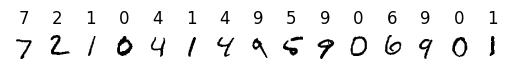

In [ ]:
_show = 15

for i in range(_show):
    plt.subplot(1, _show, i + 1)
    plt.axis('off')
    plt.imshow(X_test[i][0].numpy(), cmap='gray_r')
    plt.title(model(torch.unsqueeze(X_test[i], 0)).argmax(1).item())